In [1]:
using Pkg 
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using ReactiveMP,RxInfer,GraphPPL
using Random, Distributions, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets 
using KernelFunctions, LoopVectorization, Optim, Zygote
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix, kernelmatrix! 
import ReactiveMP: approximate_meancov, SphericalRadialCubature, log2π

┌ Warning: Error requiring `Zygote` from `ReactiveMP`
│   exception = (LoadError("/Users/nguyenhuuminhhoang/PhD/ReactiveMP.jl/ext/ReactiveMPZygoteExt/ReactiveMPZygoteExt.jl", 1, ArgumentError("Package ReactiveMP does not have Zygote in its dependencies:\n- You may have a partially installed environment. Try `Pkg.instantiate()`\n  to ensure all packages in the environment are installed.\n- Or, if you have ReactiveMP checked out for development and have\n  added Zygote as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with ReactiveMP")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000280edc66f, Ptr{Nothing} @0x0000000280edc83b, Ptr{Nothing} @0x00000001033512a3, Ptr{Nothing} @0x000000010338690b, Ptr{Nothing} @0x0000000103385717, Ptr{Nothing} @0x0000000103385a93, Ptr{Nothing} @0x0000000103386073, Ptr{Nothing} @0x0000000103386e07, Ptr{Nothing} @0x0000000119d3bed7, Ptr{Nothing} @0

## Univariate Case 

In [540]:
#Generate data 
Random.seed!(1471)
function generate_data(n,σ_x,σ_y)
    x_prev = 0.
    latent_state = Vector{Float64}(undef, n)
    observation = Vector{Float64}(undef,n)
    for i=1:n
        latent_state[i] = transition_func(x_prev) + σ_x * randn()
        observation[i] = latent_state[i] + σ_y * randn() 
        x_prev = latent_state[i]
    end
    return latent_state, observation 
end

N = 800 #number of data 
n_train = 200
n_test = N - n_train
σ_x = 1.
σ_y = 0.8
transition_func = (x) -> x - 1.5*sin(x)

#2161 (generic function with 1 method)

In [541]:
true_state, data = generate_data(N,σ_x,σ_y);
true_state_train = true_state[1:n_train]
true_state_test = true_state[n_train+1 : end];
data_train = data[1:n_train];
data_test = data[n_train+1:end];

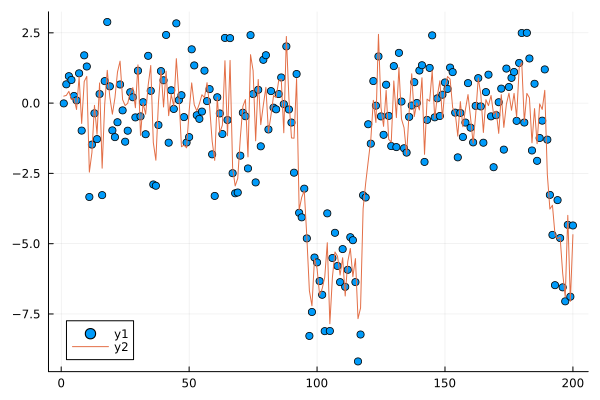

In [542]:
scatter(data_train)
plot!(true_state_train)

In [543]:
struct GPTransitionMeta{S,T,K}
    Xu          :: S
    Kuu_inverse :: T  
    Kuu         :: T
    kernel      :: K
end

GPTransitionMeta(Xu::Vector, Kuu_inverse::Matrix) = GPTransitionMeta(Xu, Kuu_inverse)
getinducinginput(meta::GPTransitionMeta) = meta.Xu 
getinverseKuu(meta::GPTransitionMeta) = meta.Kuu_inverse
getKuu(meta::GPTransitionMeta) = meta.Kuu 
getkernel(meta::GPTransitionMeta) = meta.kernel 
getparams(meta::GPTransitionMeta) = (meta.Xu, meta.Kuu, meta.Kuu_inverse)

getparams (generic function with 1 method)

In [544]:
#the correct function 
function ReactiveMP.approximate_kernel_expectation(method::AbstractApproximationMethod, g::Function, m::Real, P::Real)

    weights = ReactiveMP.getweights(method, m, P)
    points  = ReactiveMP.getpoints(method, m, P)

    gbar = g(m) - g(m)
    foreach(zip(weights, points)) do (weight, point)
        gbar += weight * g(point)
    end

    return gbar
end
function approx_mean_cov(points_generator,weights_generator, g_func)

    cs = zeros(length(weights_generator))
    norm = 0.
    mean_approx = zeros(2)

    for (index, (weight, point)) in enumerate(zip(weights_generator, points_generator))
        gv = g_func(point)
        cv = weight * gv

        # mean = mean + point * weight * g(point)
        broadcast!(*, point, point, cv)  # point *= cv
        broadcast!(+, mean_approx, mean_approx, point) # mean += point
        norm += cv

        @inbounds cs[index] = cv
    end
    broadcast!(/, mean_approx, mean_approx, norm)

    cov_approx = zeros(2, 2)
    foreach(enumerate(zip(points, cs))) do (index, (point, c))
        broadcast!(-, point, point, mean_approx)                # point -= mean
        mul!(cov_approx, point, reshape(point, (1, 2)), c, 1.0) # cov = cov + c * (point)⋅(point)' where c = weight * g(point)
    end

    broadcast!(/, cov_approx, cov_approx, norm)

    return mean_approx, cov_approx

end
# #make faster 
# function fast_approximate_kernel_expectation()

approx_mean_cov (generic function with 1 method)

In [545]:
hermite_point, hermite_w = ReactiveMP.gausshermite(121)
Unit_Normal = MvNormal(zeros(2),diageye(2))
points = ReactiveMP.getpoints(ghcubature(61), mean(Unit_Normal), cov(Unit_Normal)) #get ghcubature points 
weights = ReactiveMP.getweights(ghcubature(61), mean(Unit_Normal), cov(Unit_Normal)) #get ghcubature weights 

Base.Generator{Base.Iterators.ProductIterator{Tuple{Vector{Float64}, Vector{Float64}}}, ReactiveMP.var"#95#96"{Float64}}(ReactiveMP.var"#95#96"{Float64}(3.141592653589793), Base.Iterators.ProductIterator{Tuple{Vector{Float64}, Vector{Float64}}}(([1.6610070486206802e-46, 3.964062000995097e-41, 6.573687606722014e-37, 2.4774746124223827e-33, 3.391083975516707e-30, 2.1587655850502194e-27, 7.433580023846322e-25, 1.5315980968945824e-22, 2.0285571447032375e-20, 1.8216160573946143e-18  …  1.8216160573946143e-18, 2.0285571447032375e-20, 1.5315980968945824e-22, 7.433580023846322e-25, 2.1587655850502194e-27, 3.391083975516707e-30, 2.4774746124223827e-33, 6.573687606722014e-37, 3.964062000995097e-41, 1.6610070486206802e-46], [1.6610070486206802e-46, 3.964062000995097e-41, 6.573687606722014e-37, 2.4774746124223827e-33, 3.391083975516707e-30, 2.1587655850502194e-27, 7.433580023846322e-25, 1.5315980968945824e-22, 2.0285571447032375e-20, 1.8216160573946143e-18  …  1.8216160573946143e-18, 2.02855714470

In [590]:
struct GPTransition end 

@node GPTransition Stochastic [ out, in, u , γ] ## out: x_t , in: x_{t-1},  u: inducing points , γ: process noise 

@rule GPTransition(:out, Marginalisation) (m_in::UnivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,q_γ::GammaShapeRate, meta::GPTransitionMeta,) = begin
    γ_bar = mean(q_γ)

    E_logγ = mean(log,q_γ)
    μ_u, Σ_u = mean_cov(q_u)
    kernel = getkernel(meta)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    A = (x) -> getindex(kernelmatrix(kernel,[x],[x]),1) - getindex(kernelmatrix(kernel,[x],Xu) * Kuu_inverse * kernelmatrix(kernel,Xu,[x]),1)
    B = (x) -> kernelmatrix(kernel,[x],Xu) * Kuu_inverse
    weight_function_Z = (x) -> pdf(m_in,x) * exp(-0.5 * γ_bar * A(x) - 0.5*γ_bar * getindex(B(x) * Σ_u * B(x)',1)) * exp(0.5*E_logγ - 0.5 * log(γ_bar)) / exp(-x^2)
    weight_function_mean = (x) -> pdf(m_in,x) * exp(-0.5 * γ_bar * A(x) - 0.5*γ_bar * getindex(B(x) * Σ_u * B(x)',1)) * exp(0.5*E_logγ - 0.5 * log(γ_bar)) * getindex(B(x) * μ_u,1) / exp(-x^2)
    weight_function_y² = (x) -> pdf(m_in,x) * exp(-0.5 * γ_bar * A(x) - 0.5*γ_bar * getindex(B(x) * Σ_u * B(x)',1)) *exp(0.5*E_logγ - 0.5 * log(γ_bar)) * (getindex(B(x) * μ_u,1)^2 + 1/γ_bar) / exp(-x^2)
    Z_y = dot(hermite_w,weight_function_Z.(hermite_point))  
    E_y = dot(hermite_w,weight_function_mean.(hermite_point)) / Z_y  
    V_y = dot(hermite_w,weight_function_y².(hermite_point)) / Z_y - E_y^2

    return NormalMeanVariance(E_y,V_y)
end

@rule GPTransition(:in, Marginalisation) (m_out::UnivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,q_γ::GammaShapeRate, meta::GPTransitionMeta) = begin
    γ_bar = mean(q_γ)
    E_logγ = mean(log,q_γ)
    μ_u, Σ_u = mean_cov(q_u)
    μ_y, v_y = mean_var(m_out)
    kernel = getkernel(meta)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    A = (x) -> getindex(kernelmatrix(kernel,[x],[x]),1) - getindex(kernelmatrix(kernel,[x],Xu) * Kuu_inverse * kernelmatrix(kernel,Xu,[x]),1)
    B = (x) -> kernelmatrix(kernel,[x],Xu) * Kuu_inverse
    pdfx = (x) -> pdf(NormalMeanVariance(getindex(B(x)*μ_u,1), v_y + 1/γ_bar),μ_y)
    backward_mess = (x) -> exp(-0.5*γ_bar * A(x) - 0.5 * γ_bar * getindex(B(x) * Σ_u * B(x)',1)) * exp(0.5*E_logγ - 0.5 * log(γ_bar)) * pdfx(x)
    weight_function_Zx = (x) -> backward_mess(x) / exp(-x^2)
    weight_function_meanx = (x) -> backward_mess(x) * x / exp(-x^2)

    Z_x = dot(hermite_w,weight_function_Zx.(hermite_point))
    E_x = dot(hermite_w,weight_function_meanx.(hermite_point)) / Z_x

    weight_function_varx = (x) -> backward_mess(x) * (x - E_x)^2 / exp(-x^2)
    v_x = dot(hermite_w,weight_function_varx.(hermite_point)) / Z_x
    
    return NormalMeanVariance(E_x, v_x)
end

@marginalrule GPTransition(:out_in) (m_out::UnivariateGaussianDistributionsFamily, m_in::UnivariateGaussianDistributionsFamily, q_u::MultivariateGaussianDistributionsFamily, q_γ::GammaShapeRate, meta::GPTransitionMeta,) = begin
    γ_bar = mean(q_γ)
    μ_u, Σ_u = mean_cov(q_u)
    μ_out, v_out = mean_var(m_out)
    μ_in, v_in = mean_var(m_in)
    E_logγ = mean(log,q_γ)
    
    kernel = getkernel(meta)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    A = (x) -> getindex(kernelmatrix(kernel,[x],[x]),1) - getindex(kernelmatrix(kernel,[x],Xu) * Kuu_inverse * kernelmatrix(kernel,Xu,[x]),1)
    B = (x) -> kernelmatrix(kernel,[x],Xu) * Kuu_inverse
    
    ## Moment matching 
    logF = (z) -> -0.5 *γ_bar * A(z[2]) + 0.5 * E_logγ - 0.5*log(γ_bar)- 0.5 * γ_bar * getindex(B(z[2]) * Σ_u * B(z[2])',1) + logpdf(NormalMeanPrecision(getindex(B(z[2])*μ_u,1), γ_bar),z[1]) + 
                    logpdf(m_out,z[1]) + logpdf(m_in,z[2]) - logpdf(Unit_Normal,z)
    m_z, Σ_z = approx_mean_cov(points,weights,(z) -> exp(logF(z)))
    ## Laplace approximation
    # neg_logF = (z) -> 0.5 *γ_bar * A(z[2]) - 0.5 * E_logγ + 0.5*log(γ_bar)+ 0.5 * γ_bar * getindex(B(z[2]) * Σ_u * B(z[2])',1) - logpdf(NormalMeanPrecision(getindex(B(z[2])*μ_u,1), γ_bar),z[1]) - 
    #                     logpdf(m_out,z[1]) - logpdf(m_in,z[2])
    # res = optimize(neg_logF,[μ_out,μ_in])
    # m_z = res.minimizer

    # W_z = Zygote.hessian(neg_logF, m_z) #precision matrix 

    # return MvNormalWeightedMeanPrecision(W_z * m_z, W_z)
    return MvNormalMeanCovariance(m_z, Σ_z)
end


@rule GPTransition(:u, Marginalisation) (q_out_in::MultivariateNormalDistributionsFamily, q_γ::GammaShapeRate,meta::GPTransitionMeta) = begin
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    kernel = getkernel(meta)

    γ_bar = mean(q_γ)
    m_out_in, Σ_out_in = mean_cov(q_out_in)
    μ_y = m_out_in[1]
    μ_x, v_x = m_out_in[2], Σ_out_in[end]
    v_yx = Σ_out_in[2]
    q_x = NormalMeanVariance(μ_x,v_x)
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_x)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel, [x], Xu), q_x) + 1e-7*I 
    Ψ3 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu) * x, q_x)
    Q = (μ_y - v_yx * μ_x / v_x) * Ψ1 + v_yx / v_x * Ψ3
    W_u = γ_bar * Kuu_inverse * Ψ2 * Kuu_inverse
    ξ_u = vcat(γ_bar * Kuu_inverse * Q'...)
    return MvNormalWeightedMeanPrecision(ξ_u, W_u)
end

@rule GPTransition(:γ, Marginalisation) (q_out_in::MultivariateGaussianDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,meta::GPTransitionMeta,) = begin
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    kernel = getkernel(meta)

    μ_u, Σ_u = mean_cov(q_u)
    m_out_in, Σ_out_in = mean_cov(q_out_in)
    μ_y, v_y = m_out_in[1], Σ_out_in[1]
    μ_x, v_x = m_out_in[2], Σ_out_in[end]
    v_yx = Σ_out_in[2]
    q_x = NormalMeanVariance(μ_x,v_x)
    Ψ0 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], [x]),q_x)[]
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_x)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), q_x) + 1e-7*I 
    Ψ3 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu) * x, q_x)

    I1 = clamp(Ψ0 - tr(Kuu_inverse * Ψ2),1e-12,1e12)
    Q = (μ_y - v_yx * μ_x / v_x) * Ψ1 + v_yx / v_x * Ψ3
    I2 = v_y + μ_y^2 - 2 * getindex(Q * Kuu_inverse * μ_u,1) + tr((μ_u * μ_u' + Σ_u) * Kuu_inverse * Ψ2 * Kuu_inverse)
    return GammaShapeRate(1.5, 0.5*(I1 + I2))
end

@average_energy GPTransition (q_out_in::MultivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily, q_γ::GammaShapeRate, meta::GPTransitionMeta,) = begin
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    kernel = getkernel(meta)
    
    γ_bar = mean(q_γ)
    E_logγ = mean(log,q_γ)
    μ_u, Σ_u = mean_cov(q_u)
    m_out_in, Σ_out_in = mean_cov(q_out_in)
    μ_y, v_y = m_out_in[1], Σ_out_in[1]
    μ_x, v_x = m_out_in[2], Σ_out_in[end]
    v_yx = Σ_out_in[2]
    q_x = NormalMeanVariance(μ_x,v_x)
    Ψ0 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], [x]),q_x)[]
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_x)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), q_x) + 1e-7*I 
    Ψ3 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu) * x, q_x)

    I1 = clamp(Ψ0 - tr(Kuu_inverse * Ψ2),1e-12,1e12)
    Q = (μ_y - v_yx * μ_x / v_x) * Ψ1 + v_yx / v_x * Ψ3
    I2 = v_y + μ_y^2 - 2 * getindex(Q * Kuu_inverse * μ_u,1) + tr((μ_u * μ_u' + Σ_u) * Kuu_inverse * Ψ2 * Kuu_inverse)
    return 0.5*γ_bar*(I1 + I2) + 0.5*(log2π - E_logγ)
end

In [591]:
@model function gpssm(n,Kuu)
    y = datavar(Float64,n)
    x = randomvar(n)

    u ~ MvNormalMeanCovariance(zeros(size(Kuu,1)), Kuu)
    w ~ GammaShapeRate(0.1,0.01)
    x0 ~ NormalMeanVariance(0, 50.)
    x_prev = x0
    for i=1:n
        x[i] ~ GPTransition(x_prev,u,w) where { q = q(out,in)q(u)q(γ) }  #structured mean-field assumption
        y[i] ~ NormalMeanVariance(x[i],σ_y^2)
        x_prev = x[i]
    end
end

In [592]:
@meta function gpssm_meta(Xu,Kuu_inverse,Kuu,kernel_gp)
    GPTransition(x,u) -> GPTransitionMeta(Xu,Kuu_inverse,Kuu,kernel_gp)
end

gpssm_meta (generic function with 1 method)

In [593]:
Nu = 70; #number of inducing points 
Xu = range(-10,3;length=Nu);

mean_gp     = (x) -> 0
# kernel_gp   =    1.1 *with_lengthscale(Matern32Kernel(), 1.5) + 5*with_lengthscale(Matern52Kernel(),1.2) + with_lengthscale(PeriodicKernel(),3.14)
kernel_gp   =  5*with_lengthscale(Matern52Kernel(),1.2) + 6 * with_lengthscale(SEKernel(),2.1)


Kuu = kernelmatrix(kernel_gp,Xu,Xu) + 1e-7*I;
Kuu_inverse = cholinv(Kuu);

In [594]:
#run inference 
niter = 25;

infer_result = inference(
    model = gpssm(n_train,Kuu),
    iterations = niter,
    data = (y = data_train,),
    initmarginals = (u = MvNormalMeanCovariance(zeros(size(Kuu,1)), Kuu),w = GammaShapeRate(0.1,0.01),),
    meta = gpssm_meta(Xu,Kuu_inverse,Kuu,kernel_gp),
    returnvars = (x = KeepLast(), u = KeepLast(),w = KeepLast(),),
    free_energy = true,
    showprogress = true
) 

Progress:   8%|███▎                                     |  ETA: 0:17:30

Progress:  12%|████▉                                    |  ETA: 0:16:37

Progress:  16%|██████▌                                  |  ETA: 0:15:42

Progress:  20%|████████▎                                |  ETA: 0:14:54

Progress:  24%|█████████▉                               |  ETA: 0:14:07

Progress:  28%|███████████▌                             |  ETA: 0:13:23

Progress:  32%|█████████████▏                           |  ETA: 0:12:38

Progress:  36%|██████████████▊                          |  ETA: 0:12:03

Progress:  40%|████████████████▍                        |  ETA: 0:11:18

Progress:  44%|██████████████████                       |  ETA: 0:10:34

Progress:  48%|███████████████████▋                     |  ETA: 0:09:48

Progress:  52%|█████████████████████▍                   |  ETA: 0:09:04

Progress:  56%|███████████████████████                  |  ETA: 0:08:17

Progress:  60%|████████████████████████▋                |  ETA: 0:07:30

Progress:  64%|██████████████████████████▎              |  ETA: 0:06:44

Progress:  68%|███████████████████████████▉             |  ETA: 0:05:59

Progress:  72%|█████████████████████████████▌           |  ETA: 0:05:14

Progress:  76%|███████████████████████████████▏         |  ETA: 0:04:28

Progress:  80%|████████████████████████████████▊        |  ETA: 0:03:43

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:02:58

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:02:14

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:01:29

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:45

Progress: 100%|█████████████████████████████████████████| Time: 0:18:40


Inference results:
  Posteriors       | available for (w, u, x)
  Free Energy:     | Real[1160.11, 913.743, 792.323, 682.662, 589.272, 518.272, 468.38, 435.439, 414.751, 402.378  …  388.398, 388.39, 388.419, 388.456, 388.49, 388.517, 388.539, 388.555, 388.567, 388.575]


In [595]:
#get results
qu = infer_result.posteriors[:u]
qx = infer_result.posteriors[:x]
qw = infer_result.posteriors[:w]
;

In [596]:
mean(qw)

0.7126492618207394

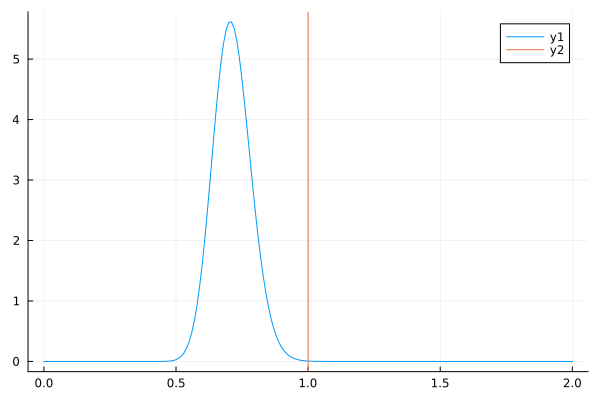

In [597]:
w_axis = collect(0:0.01:2)
plot(w_axis, pdf.(qw,w_axis))
vline!([1/σ_x^2])

In [598]:
true_u = transition_func.(Xu);

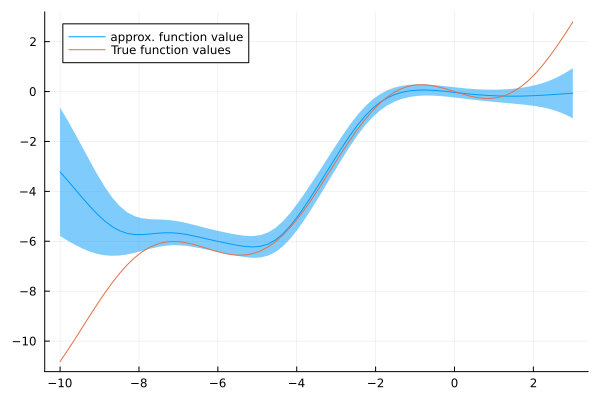

In [599]:
plot(Xu,mean(qu),ribbon = sqrt.(var(qu)),label="approx. function value")
plot!(Xu,true_u,label="True function values")

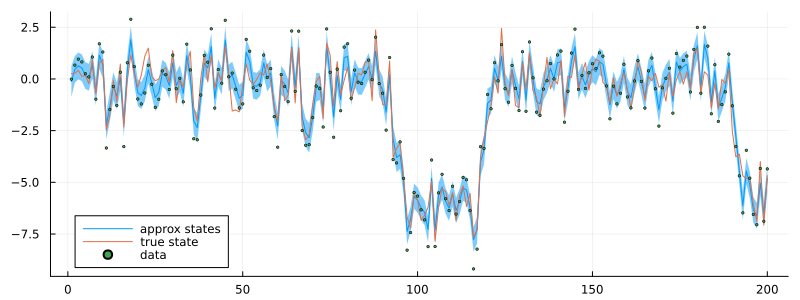

In [600]:
plot(mean.(qx), ribbon = sqrt.(var.(qx)),label="approx states", size=[800,300])
plot!(true_state_train, label="true state")
scatter!(data_train,label="data",ms=1.4)
# lens!([220, 300], [-12.5, -2.5], inset = (1, bbox(.08, .6, 0.3, 0.25)))

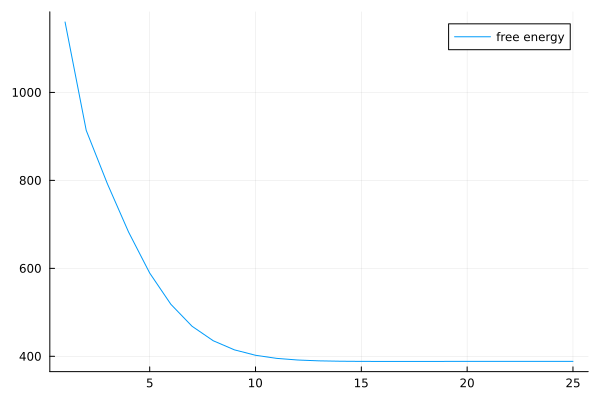

In [601]:
plot(infer_result.free_energy,label="free energy")


## Naive Variational Mean Field

In [606]:

@rule GPTransition(:out, Marginalisation) (q_in::UnivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,q_γ::GammaShapeRate, meta::GPTransitionMeta,) = begin
    Q = 1/mean(q_γ) 
    Kuu_inverse = getinverseKuu(meta)
    Xu = getinducinginput(meta)
    kernel = getkernel(meta)
    μ_u = mean(q_u)
    kxu = (x) -> kernelmatrix(kernel, [x], Xu)

    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121), kxu, q_in)
    return NormalMeanVariance(getindex(Ψ1 * Kuu_inverse * μ_u, 1), Q)
end

@rule GPTransition(:in, Marginalisation) (q_out::UnivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,q_γ::GammaShapeRate, meta::GPTransitionMeta) = begin
    γ_bar = mean(q_γ) 
    E_logγ = mean(log,q_γ)
    kernel = getkernel(meta)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    A = (x) -> kernelmatrix(kernel,[x],[x]) .- kernelmatrix(kernel,[x],Xu) * Kuu_inverse * kernelmatrix(kernel,Xu,[x])
    B = (x) -> kernelmatrix(kernel, [x], Xu) * Kuu_inverse
    
    μ_y, v_y = mean_var(q_out)
    μ_u, Σ_u = mean_cov(q_u)

    pdfx = (x) -> pdf(NormalMeanVariance(getindex(B(x)*μ_u,1), 1/γ_bar), μ_y)
    backward_mess = (x) -> exp(-0.5*γ_bar * getindex(A(x),1) - 0.5 * γ_bar * getindex(B(x) * Σ_u * B(x)',1) -0.5 * γ_bar * v_y) * exp(0.5*E_logγ - 0.5 * log(γ_bar)) * pdfx(x)

    weight_function_Zx = (x) -> backward_mess(x) / exp(-x^2)
    weight_function_Ex = (x) -> backward_mess(x) * x / exp(-x^2)
    weight_function_Ex² = (x) -> backward_mess(x) * x^2 / exp(-x^2)

    Z_x = dot(hermite_w,weight_function_Zx.(hermite_point))
    E_x = dot(hermite_w,weight_function_Ex.(hermite_point)) / Z_x
    E_x² = dot(hermite_w,weight_function_Ex².(hermite_point)) / Z_x
    V_x = E_x² - E_x^2
    return NormalMeanVariance(E_x,V_x)
end


@rule GPTransition(:u, Marginalisation) (q_out::UnivariateNormalDistributionsFamily, q_in::UnivariateNormalDistributionsFamily, q_γ::GammaShapeRate,meta::GPTransitionMeta) = begin
    σ² = 1/mean(q_γ) 
    μ_y = mean(q_out)
    Xu = getinducinginput(meta)
    Kuu = getKuu(meta)
    kernel = getkernel(meta)

    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_in)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), q_in) + 1e-7*I 

    μ_u = μ_y * Kuu * cholinv(Ψ2)*Ψ1'
    Σ_u = σ² * Kuu * cholinv(Ψ2) * Kuu 
    return MvNormalMeanCovariance(vcat(μ_u...), Σ_u)
end

@rule GPTransition(:γ, Marginalisation) (q_out::UnivariateGaussianDistributionsFamily, q_in::UnivariateGaussianDistributionsFamily,q_u::MultivariateNormalDistributionsFamily,meta::GPTransitionMeta,) = begin
    μ_y, v_y = mean_var(q_out)
    μ_u, Σ_u = mean_cov(q_u)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    kernel = getkernel(meta)
    Ψ0 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], [x]),q_in)[]
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_in)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), q_in) + 1e-7*I 

    I1 = clamp(Ψ0 - tr(Kuu_inverse * Ψ2),1e-12,1e12)
    I2 = clamp(μ_y^2 + v_y -2*μ_y * (Ψ1 * Kuu_inverse * μ_u)[] + tr(Kuu_inverse * (Σ_u + μ_u * μ_u') * Kuu_inverse * Ψ2 ), 1e-12,1e12)

    return GammaShapeRate(1.5, 0.5*(I1 + I2))
end



@average_energy GPTransition (q_out::UnivariateNormalDistributionsFamily, q_in::UnivariateGaussianDistributionsFamily, q_u::MultivariateNormalDistributionsFamily, q_γ::GammaShapeRate, meta::GPTransitionMeta,) = begin
    γ_bar = mean(q_γ)
    E_logγ = mean(log,q_γ)
    μ_y, v_y = mean_var(q_out)
    μ_u, Σ_u = mean_cov(q_u)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    kernel = getkernel(meta)
    Ψ0 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], [x]),q_in)[]
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_in)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), q_in) + 1e-7*I 

    I1 = Ψ0 - tr(Kuu_inverse * Ψ2)
    I2 = μ_y^2 + v_y -2*μ_y * (Ψ1 * Kuu_inverse * μ_u)[] + tr(Kuu_inverse * (Σ_u + μ_u * μ_u') * Kuu_inverse * Ψ2 )

    return 0.5*(I1*γ_bar - E_logγ + log(2π) + I2 * γ_bar) 
end

In [607]:
@model function gpssm_naiveMF(n,Kuu)
    y = datavar(Float64,n)
    x = randomvar(n)

    u ~ MvNormalMeanCovariance(zeros(size(Kuu,1)), Kuu)
    w ~ GammaShapeRate(0.1,0.01)
    x0 ~ NormalMeanVariance(0, 50.)
    x_prev = x0
    for i=1:n
        x[i] ~ GPTransition(x_prev,u,w) where { q = q(out)q(in)q(u)q(γ) }  #mean-field assumption
        y[i] ~ NormalMeanVariance(x[i],σ_y^2)
        x_prev = x[i]
    end
end

In [608]:
niter = 25;

naivemeanfield_infer_result = inference(
    model = gpssm_naiveMF(n_train,Kuu),
    iterations = niter,
    data = (y = data_train,),
    initmarginals = (u = MvNormalMeanCovariance(zeros(size(Kuu,1)), Kuu),w = GammaShapeRate(0.1,0.01),x = NormalMeanVariance(0,50),),
    meta = gpssm_meta(Xu,Kuu_inverse,Kuu,kernel_gp),
    returnvars = (x = KeepLast(), u = KeepLast(),w = KeepLast(),),
    free_energy = true,
    showprogress = true
) 

Progress:   8%|███▎                                     |  ETA: 0:03:23

Progress:  12%|████▉                                    |  ETA: 0:03:04

Progress:  16%|██████▌                                  |  ETA: 0:02:52

Progress:  20%|████████▎                                |  ETA: 0:02:40

Progress:  24%|█████████▉                               |  ETA: 0:02:31

Progress:  28%|███████████▌                             |  ETA: 0:02:25

Progress:  32%|█████████████▏                           |  ETA: 0:02:16

Progress:  36%|██████████████▊                          |  ETA: 0:02:07

Progress:  40%|████████████████▍                        |  ETA: 0:02:00

Progress:  44%|██████████████████                       |  ETA: 0:01:52

Progress:  48%|███████████████████▋                     |  ETA: 0:01:44

Progress:  52%|█████████████████████▍                   |  ETA: 0:01:37

Progress:  56%|███████████████████████                  |  ETA: 0:01:28

Progress:  60%|████████████████████████▋                |  ETA: 0:01:20

Progress:  64%|██████████████████████████▎              |  ETA: 0:01:12

Progress:  68%|███████████████████████████▉             |  ETA: 0:01:04

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:57

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:50

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:41

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:33

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:24

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:16

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:08

Progress: 100%|█████████████████████████████████████████| Time: 0:03:20


Inference results:
  Posteriors       | available for (w, u, x)
  Free Energy:     | Real[454.784, 410.473, 400.027, 397.526, 396.854, 396.645, 396.57, 396.539, 396.525, 396.518  …  396.511, 396.511, 396.511, 396.511, 396.511, 396.511, 396.511, 396.511, 396.511, 396.511]


In [609]:
qu_naivemeanfield = naivemeanfield_infer_result.posteriors[:u]
qx_naivemeanfield = naivemeanfield_infer_result.posteriors[:x]
qw_naivemeanfield = naivemeanfield_infer_result.posteriors[:w]
;

In [610]:
mean(qw_naivemeanfield)

0.5621856572628865

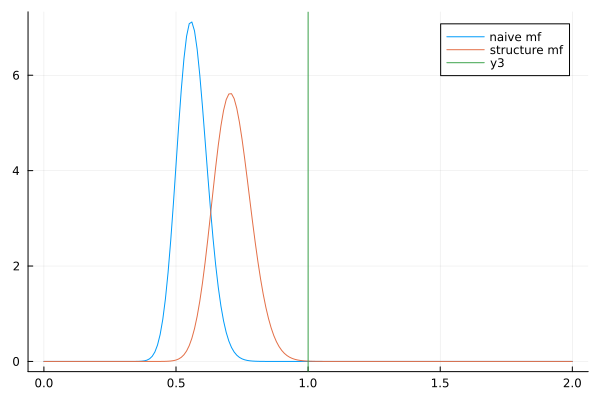

In [611]:
w_axis = collect(0:0.01:2)
plot(w_axis, pdf.(qw_naivemeanfield,w_axis), label="naive mf")
plot!(w_axis, pdf.(qw, w_axis), label = "structure mf")
vline!([1/σ_x^2])

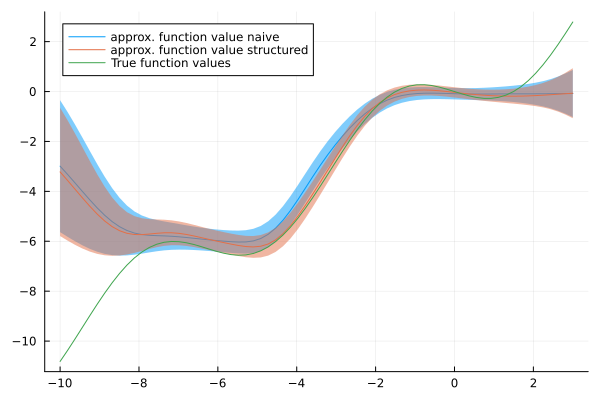

In [651]:
plot(Xu,mean(qu_naivemeanfield),ribbon = sqrt.(var(qu_naivemeanfield)),label="approx. function value naive")
plot!(Xu,mean(qu),ribbon = sqrt.(var(qu)),label="approx. function value structured")
plot!(Xu,true_u,label="True function values")

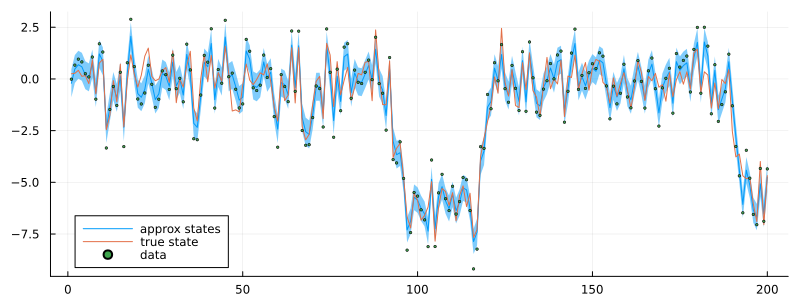

In [613]:
plot(mean.(qx_naivemeanfield), ribbon = sqrt.(var.(qx_naivemeanfield)),label="approx states", size=[800,300])
plot!(true_state_train, label="true state")
scatter!(data_train,label="data",ms=1.4)
# lens!([220, 300], [-12.5, -2.5], inset = (1, bbox(.08, .6, 0.3, 0.25)))

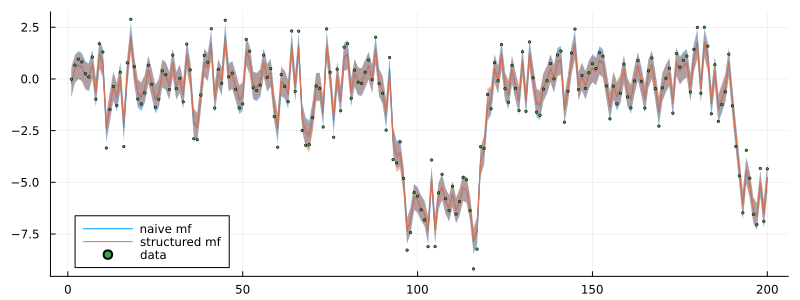

In [614]:
plot(mean.(qx_naivemeanfield), ribbon = sqrt.(var.(qx_naivemeanfield)),label="naive mf", size=[800,300])
plot!(mean.(qx), ribbon = sqrt.(var.(qx)),label="structured mf")
scatter!(data_train,label="data",ms=1.4)
# lens!([220, 270], [-10.1, -1.5], inset = (1, bbox(.08, .6, 0.3, 0.25)))

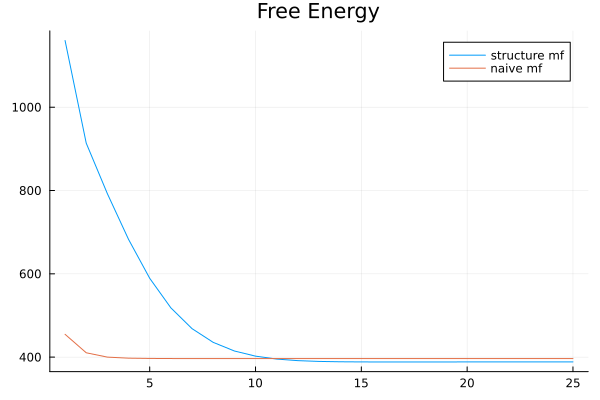

In [617]:
plot(infer_result.free_energy,label="structure mf")
plot!(naivemeanfield_infer_result.free_energy, label="naive mf")
title!("Free Energy")

In [ ]:
### store scrap code 
# kernel_gp_theta = (θ) -> θ[1]*with_lengthscale(Matern52Kernel(),θ[2]) + θ[3] * with_lengthscale(SEKernel(),θ[4])
# μ_u, Σ_u = mean_cov(qu)
# function nlogllh(θ)
#     Kuu = kernelmatrix(kernel_gp_theta(θ),Xu,Xu) + Diagonal(Σ_u) + 1e-7*I
#     Kuu_inv = inv(Kuu)
#     return Nu/2 * log(2π) + 1/2 * log(det(Kuu)) + 1/2 * μ_u' * Kuu_inv * μ_u
# end
# function myGDoptimizer(func, init, η; niter = 3000)
#     grad_func = let f = func 
#         (x) -> Zygote.gradient(f, x)
#     end
#     opt_val = init 
#     for i=1:niter 
#         func_prev = func(opt_val)
#         grad = grad_func(opt_val)[1]
#         opt_val = opt_val .-  η.*grad 
#         if abs(func_prev - func(opt_val)) < 1e-12
#             @show i 
#             return opt_val
#         end 
#     end
#     return opt_val
# end

# θ_init = [ 5, 1.2, 6, 2.1]
# Zygote.gradient(nlogllh, θ_init)
# X = collect(-20:0.1:10);

# Kuu_opt = kernelmatrix(kernel_gp_theta(opt_value),Xu,Xu) + 1e-7*I;
# Kxu_opt = kernelmatrix(kernel_gp_theta(opt_value),X,Xu);
# Kxx_opt = kernelmatrix(kernel_gp_theta(opt_value),X,X);

# mX = Kxu_opt * inv(Kuu_opt) * μ_u 
# VX = Kxx_opt - Kxu_opt * inv(Kuu_opt) * Kxu_opt' +  1e-7*I
# ;